In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/home/ilopvonem/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Read data and parse index as datetime

In [2]:
data = pd.read_csv('../data/data.csv', encoding='utf-8', index_col=0)
data.index = pd.to_datetime(data.index)
data.shape

(1098199, 5)

In [3]:
data.head()

,asset_id,operational_mode,s1,s2,s3
2016-01-01 00:00:00,33,a,-0.694638,12.680544,0.503953
2016-01-01 00:05:00,33,a,5.012288,11.264028,0.953424
2016-01-01 00:10:00,33,a,4.903325,10.882658,-0.081722
2016-01-01 00:15:00,33,a,-0.612916,18.496431,3.023717
2016-01-01 00:20:00,33,a,-1.184970,12.108489,7.205164


In [4]:
data.isnull().sum()

asset_id            0
operational_mode    0
s1                  5
s2                  0
s3                  1
dtype: int64

There are two options here to remove those rows that contain NULL values or to replace NULL values with 0.

I chose the latter, even though it won't be a great loss to remove 6 (potentially) rows.

In [5]:
data = data.fillna(0)
data.isnull().sum()

asset_id            0
operational_mode    0
s1                  0
s2                  0
s3                  0
dtype: int64

## Test whether all is good

In [6]:
mask = (data.index >= '2016-6-2 00:15:00') & (data.index <= '2016-6-2 00:30:00')
data.loc[mask]

,asset_id,operational_mode,s1,s2,s3
2016-06-02 00:15:00,20,e,-1.99,3.91,9.08
2016-06-02 00:20:00,20,e,-1.84,4.02,9.08
2016-06-02 00:25:00,20,e,-1.80,4.18,8.92
2016-06-02 00:30:00,20,e,-1.84,4.10,9.08
2016-06-02 00:15:00,31,f,5.05,6.05,1.04
2016-06-02 00:20:00,31,f,6.40,6.63,0.34
2016-06-02 00:25:00,31,f,7.04,6.70,-0.08
2016-06-02 00:30:00,31,f,7.01,6.02,-0.27
2016-06-02 00:15:00,19,e,8.96,-0.80,2.26
2016-06-02 00:20:00,19,e,9.00,-0.80,2.30


Describe the data to see if there is anything striking.

By the looks of std values **s2** might be of interest.

In [7]:
data.describe()

,asset_id,s1,s2,s3
count,1.098199e+06,1.098199e+06,1.098199e+06,1.098199e+06
mean,1.886065e+01,6.628558e-01,7.255648e+00,4.110597e-01
std,1.021424e+01,6.849067e+00,6.746211e+00,4.754113e+00
min,1.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,-2.870000e+00,3.170000e+00,-2.220000e+00
50%,1.900000e+01,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,1.995000e+01,2.004000e+01,1.961000e+01


## Define functions here:

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
import keras.backend as K
import keras

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

Using TensorFlow backend.
/home/ilopvonem/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Check out the data balance

In [10]:
data['operational_mode'].unique()

array(['a', 'b', 'c', 'd', 'f', 'e'], dtype=object)

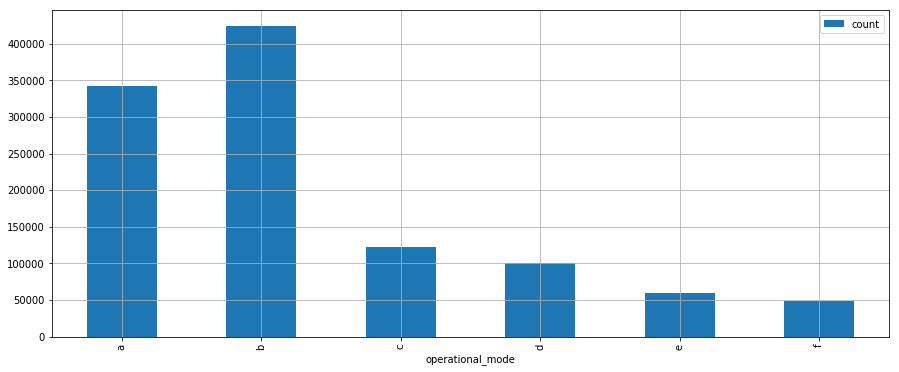

In [11]:
data['count'] = 1
sep_count = data[['operational_mode', 'count']].groupby('operational_mode').sum()
assert sep_count.sum()['count'] == data.shape[0]

sep_count.plot(kind='bar', grid=True)
plt.show()

The data looks quite imbalanced. There are much more examples of operational modes *a* and *b*, while operational modes *c, d, e, f* are quite limited.

I might need to use some re-sampling techniques to balance it.

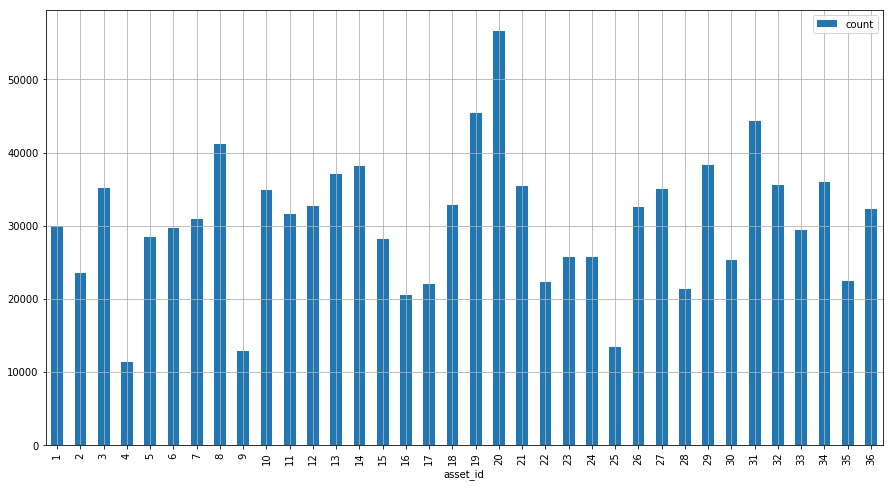

In [12]:
sep_count = data[['count', 'asset_id']].groupby('asset_id').count()
assert sep_count.sum()['count'] == data.shape[0]

sep_count.plot(kind='bar', grid=True, figsize=(15,8))
plt.show()

The data for machines *4, 9, 25* is quite limited.

However, for the classification problem I think to use all the data (combined together) as opposed to build a separate model for each machine. In this way I will be able to use the entirety of the data (much more training examples).

Shape of asset 20: (56632, 6)


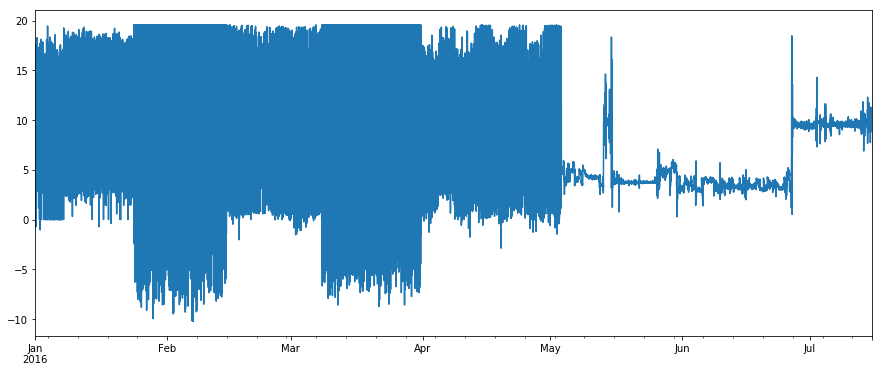

In [13]:
asset20 = data[data['asset_id']==20]
print(f"Shape of asset 20: {asset20.shape}")
date_mask = (asset20.index >= '2016-2-2 03:00:00') & (asset20.index <= '2016-2-2 09:00:00')
asset20.drop('asset_id', axis=1)['s2'].plot()
plt.show()

I don't understand this. 

* Why does the data for Jan until May looks so messy?
* Is this data usable?
* What actually caused this and could this be prevented for the future?

/home/ilopvonem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/home/ilopvonem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


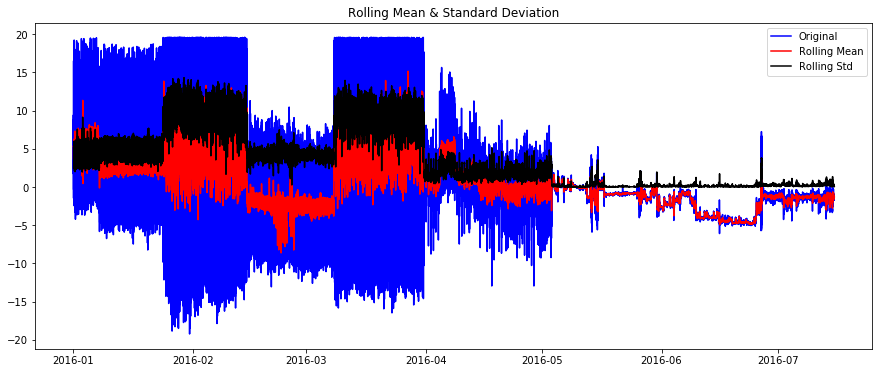

Results of Dickey-Fuller Test:
Test Statistic                -5.842024e+00
p-value                        3.758006e-07
#Lags Used                     5.700000e+01
Number of Observations Used    5.657400e+04
Critical Value (1%)           -3.430466e+00
Critical Value (5%)           -2.861591e+00
Critical Value (10%)          -2.566797e+00
dtype: float64


In [15]:
test_stationarity(asset20['s1'])

Test stationarity even though time series data is visibly not stationary.

(11128, 6)


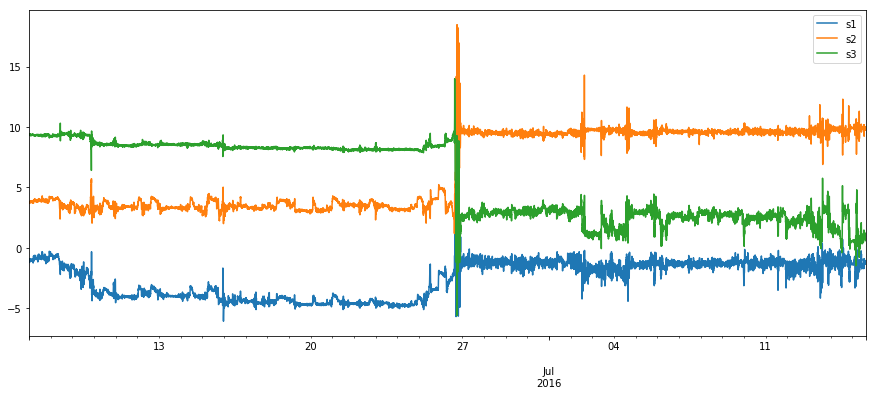

In [16]:
data[data.index >= '2016-6-7 00:00:00'][['s1', 's2', 's3']].plot()
not_messy_data = data[data.index >= '2016-6-7 00:00:00']
print(not_messy_data.shape)
plt.show()

In [17]:
100 - (not_messy_data.shape[0] / data.shape[0]) * 100.0

98.98670459543307

If I slice out the messy looking data the time series looks much better, but we loose 98.98% of the data.

/home/ilopvonem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/home/ilopvonem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


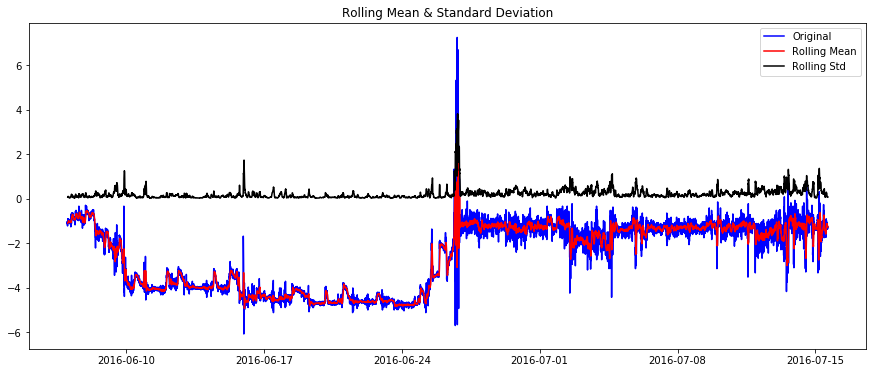

Results of Dickey-Fuller Test:
Test Statistic                    -1.866195
p-value                            0.348127
#Lags Used                        38.000000
Number of Observations Used    11089.000000
Critical Value (1%)               -3.430940
Critical Value (5%)               -2.861801
Critical Value (10%)              -2.566909
dtype: float64


In [18]:
test_stationarity(not_messy_data['s1'])

In [19]:
# ts_log = np.log(not_messy_data['s1'])
# plt.plot(ts_log)
# ts_log.head()

## Data processing

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [21]:
def normalize(series):
    values = series.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
    return scaler.transform(values)

In [22]:
def standardize(series):
    values = series.values
    values = values.reshape((len(values), 1))
    scaler = StandardScaler()
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    return scaler.transform(values)

## Normalize the data:

In [23]:
data['norm_s1'] = normalize(data['s1'])
data['norm_s2'] = normalize(data['s2'])
data['norm_s3'] = normalize(data['s3'])
data.head()

Min: -19.610000, Max: 19.950000
Min: -19.610000, Max: 20.040000
Min: -19.800000, Max: 19.610000


,asset_id,operational_mode,s1,s2,s3,count,norm_s1,norm_s2,norm_s3
2016-01-01 00:00:00,33,a,-0.694638,12.680544,0.503953,1,0.478144,0.814390,0.515198
2016-01-01 00:05:00,33,a,5.012288,11.264028,0.953424,1,0.622404,0.778664,0.526603
2016-01-01 00:10:00,33,a,4.903325,10.882658,-0.081722,1,0.619649,0.769046,0.500337
2016-01-01 00:15:00,33,a,-0.612916,18.496431,3.023717,1,0.480209,0.961070,0.579135
2016-01-01 00:20:00,33,a,-1.184970,12.108489,7.205164,1,0.465749,0.799962,0.685236


## Standardize the data:

In [24]:
data['stand_s1'] = standardize(data['s1'])
data['stand_s2'] = standardize(data['s2'])
data['stand_s3'] = standardize(data['s3'])
data.head()

Mean: 0.662856, StandardDeviation: 6.849064
Mean: 7.255648, StandardDeviation: 6.746208
Mean: 0.411060, StandardDeviation: 4.754111


,asset_id,operational_mode,s1,s2,s3,count,norm_s1,norm_s2,norm_s3,stand_s1,stand_s2,stand_s3
2016-01-01 00:00:00,33,a,-0.694638,12.680544,0.503953,1,0.478144,0.814390,0.515198,-0.198201,0.804140,0.019540
2016-01-01 00:05:00,33,a,5.012288,11.264028,0.953424,1,0.622404,0.778664,0.526603,0.635040,0.594168,0.114083
2016-01-01 00:10:00,33,a,4.903325,10.882658,-0.081722,1,0.619649,0.769046,0.500337,0.619131,0.537637,-0.103654
2016-01-01 00:15:00,33,a,-0.612916,18.496431,3.023717,1,0.480209,0.961070,0.579135,-0.186269,1.666237,0.549558
2016-01-01 00:20:00,33,a,-1.184970,12.108489,7.205164,1,0.465749,0.799962,0.685236,-0.269793,0.719343,1.429101


# Feature engineering and modelling

In [25]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, SimpleRNN
from keras.layers import MaxPooling2D, Conv1D
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
numpy.random.seed(7)

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.operational_mode.values)
data['y'] = le.transform(data.operational_mode.values)

## Feature Engineering

Add new features for both the normalized and standardized data:

* Sensor reading at time T-1
* Sensor reading at time T-2
* Difference between sensor reading T - (T-1)
* Difference between sensor reading (T-1) - (T-2)

In [27]:
data2 = data.copy()
data2['prev_norm_s1'] = data2.groupby(['asset_id'])['norm_s1'].shift()
data2['prev_norm_s2'] = data2.groupby(['asset_id'])['norm_s2'].shift()
data2['prev_norm_s3'] = data2.groupby(['asset_id'])['norm_s3'].shift()
data2['prev_norm_1_diff'] = data2['prev_norm_s1'] - data2['norm_s1']
data2['prev_norm_2_diff'] = data2['prev_norm_s2'] - data2['norm_s2']
data2['prev_norm_3_diff'] = data2['prev_norm_s3'] - data2['norm_s3']

data2['prev_stand_s1'] = data2.groupby(['asset_id'])['stand_s1'].shift()
data2['prev_stand_s2'] = data2.groupby(['asset_id'])['stand_s2'].shift()
data2['prev_stand_s3'] = data2.groupby(['asset_id'])['stand_s3'].shift()
data2['prev_stand_1_diff'] = data2['prev_stand_s1'] - data2['stand_s1']
data2['prev_stand_2_diff'] = data2['prev_stand_s2'] - data2['stand_s2']
data2['prev_stand_3_diff'] = data2['prev_stand_s3'] - data2['stand_s3']

data2 = data2.dropna()

In [28]:
data2['prev_norm_s1-1'] = data2.groupby(['asset_id'])['norm_s1'].shift(2)
data2['prev_norm_s2-1'] = data2.groupby(['asset_id'])['norm_s2'].shift(2)
data2['prev_norm_s3-1'] = data2.groupby(['asset_id'])['norm_s3'].shift(2)
data2['prev_norm_1_diff-1'] = data2['prev_norm_s1-1'] - data2['prev_norm_s1']
data2['prev_norm_2_diff-1'] = data2['prev_norm_s2-1'] - data2['prev_norm_s2']
data2['prev_norm_3_diff-1'] = data2['prev_norm_s3-1'] - data2['prev_norm_s3']

data2['prev_stand_s1-1'] = data2.groupby(['asset_id'])['stand_s1'].shift(2)
data2['prev_stand_s2-1'] = data2.groupby(['asset_id'])['stand_s2'].shift(2)
data2['prev_stand_s3-1'] = data2.groupby(['asset_id'])['stand_s3'].shift(2)
data2['prev_stand_1_diff-1'] = data2['prev_stand_s1-1'] - data2['prev_stand_s1']
data2['prev_stand_2_diff-1'] = data2['prev_stand_s2-1'] - data2['prev_stand_s2']
data2['prev_stand_3_diff-1'] = data2['prev_stand_s3-1'] - data2['prev_stand_s3']

data2 = data2.dropna()
data2.head()

,asset_id,operational_mode,s1,s2,s3,count,norm_s1,norm_s2,norm_s3,stand_s1,...,prev_norm_s3-1,prev_norm_1_diff-1,prev_norm_2_diff-1,prev_norm_3_diff-1,prev_stand_s1-1,prev_stand_s2-1,prev_stand_s3-1,prev_stand_1_diff-1,prev_stand_2_diff-1,prev_stand_3_diff-1
2016-01-01 00:15:00,33,a,-0.612916,18.496431,3.023717,1,0.480209,0.961070,0.579135,-0.186269,...,0.526603,0.002754,0.009618,0.026266,0.635040,0.594168,0.114083,0.015909,0.056531,0.217737
2016-01-01 00:20:00,33,a,-1.184970,12.108489,7.205164,1,0.465749,0.799962,0.685236,-0.269793,...,0.500337,0.139440,-0.192025,-0.078798,0.619131,0.537637,-0.103654,0.805401,-1.128600,-0.653211
2016-01-01 00:25:00,33,a,1.375655,-2.492524,-6.510526,1,0.530477,0.431714,0.337211,0.104073,...,0.579135,0.014460,0.161108,-0.106101,-0.186269,1.666237,0.549558,0.083523,0.946894,-0.879543
2016-01-01 00:30:00,33,a,-0.612916,10.569390,5.706926,1,0.480209,0.761145,0.647220,-0.186269,...,0.685236,-0.064728,0.368247,0.348026,-0.269793,0.719343,1.429101,-0.373865,2.164329,2.885017
2016-01-01 00:35:00,33,a,-0.503953,13.947236,7.055340,1,0.482964,0.846336,0.681435,-0.170360,...,0.337211,0.050267,-0.329430,-0.310009,0.104073,-1.444985,-1.455916,0.290342,-1.936186,-2.569871


## Train/Test split

In [29]:
XX_train, XX_test, yy_train, yy_test = train_test_split(
    data2.drop(['operational_mode', 'y', 's1', 's2', 's3', 'count'], axis=1), data2.y, test_size=0.33, random_state=42)

Data split - use 2/3 for training and 1/3 for testing.

## Function for one hot encoding

In [30]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

## Check label counts

In [32]:
print("After OverSampling, counts of label '0': {}".format(sum(yy_train==0)))
print("After OverSampling, counts of label '1': {}".format(sum(yy_train==1)))
print("After OverSampling, counts of label '2': {}".format(sum(yy_train==2)))
print("After OverSampling, counts of label '3': {}".format(sum(yy_train==3)))
print("After OverSampling, counts of label '4': {}".format(sum(yy_train==4)))
print("After OverSampling, counts of label '5': {}".format(sum(yy_train==5)))

After OverSampling, counts of label '0': 229025
After OverSampling, counts of label '1': 284336
After OverSampling, counts of label '2': 82211
After OverSampling, counts of label '3': 67545
After OverSampling, counts of label '4': 40122
After OverSampling, counts of label '5': 32481


## Reshaping

In [33]:
sX_train = np.expand_dims(XX_train, 2)
sX_test = np.expand_dims(XX_test, 2)
sX_train.shape

(735720, 31, 1)

In [34]:
train_Y = convert_to_one_hot(yy_train, C = 6)
test_Y  = convert_to_one_hot(yy_test,  C = 6)

/home/ilopvonem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


## Training the LSTM

In [35]:
from keras.layers.advanced_activations import LeakyReLU

embedding_vecor_length = 32
n_features = sX_train.shape[1]
n_output = sX_train.shape[2]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(n_features,n_output)))
model.add(LeakyReLU(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add( LSTM(64, dropout=0.2, recurrent_dropout=0.2) ) #, return_sequences=True
model.add(LeakyReLU(0.2))
# model.add( LSTM(5) )
# model.add(Flatten())
model.add( Dense(6, activation='softmax') )
rmsp = keras.optimizers.RMSprop(lr=0.05, rho=0.9, epsilon=0.01, decay=0.0)
model.compile( loss=rmse, optimizer=rmsp, metrics=['mae', 'accuracy'] )
print(model.summary())
model.fit(sX_train, train_Y, validation_data=(sX_test, test_Y), epochs=3, batch_size=128)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 31, 64)            256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 31, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390    

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

test = model.evaluate( sX_test, test_Y, verbose=1 )
print()
print("Train Loss (RMSE): ", test[0])
print("Mean Absolute Error:  ", test[1])
print("Accuracy:  ", test[2])
print()

pred = model.predict(sX_test)
Y_pred = np.argmax(pred, axis=1)
Y_true = np.argmax(test_Y,  axis=1)

print("Confusion Matrix:")
print(confusion_matrix(Y_true, Y_pred))

print("\n Classification Report:")
target_classes = ['Operational Mode "A"', 'Operational Mode "B"', 'Operational Mode "C"',
                  'Operational Mode "D"', 'Operational Mode "E"', 'Operational Mode "F"']
print(classification_report(Y_true, Y_pred, target_names=target_classes))

362240/362371 [============================>.] - ETA: 0s
Test Loss:  0.2347315711611319
Mean Absolute Error:   0.10976900184693462
Accuracy:   0.767760113254096

Confusion Matrix:
[[100853  10309    825    811    222    111]
 [  6314 126173   4659   2185    100    541]
 [  5927  20951  10258   2396     96   1030]
 [  4975  17442   3893   6083     68    419]
 [    23     43     82     24  19544    101]
 [    12    129    362     29     78  15303]]

 Classification Report:
                      precision    recall  f1-score   support

Operational Mode "A"       0.85      0.89      0.87    113131
Operational Mode "B"       0.72      0.90      0.80    139972
Operational Mode "C"       0.51      0.25      0.34     40658
Operational Mode "D"       0.53      0.19      0.27     32880
Operational Mode "E"       0.97      0.99      0.98     19817
Operational Mode "F"       0.87      0.96      0.92     15913

           micro avg       0.77      0.77      0.77    362371
           macro avg      

## CNN LSTM with Euclidian Distance

In [38]:
# data3 = data2.copy()
# data3['s1_s2_eucl'] = (data2['norm_s1'] - data2['norm_s2']).apply(lambda x: sqrt(x**2))
# data3['s2_s3_eucl'] = (data2['norm_s2'] - data2['norm_s3']).apply(lambda x: sqrt(x**2))
# data3['s1_s3_eucl'] = (data2['norm_s1'] - data2['norm_s3']).apply(lambda x: sqrt(x**2))

# data3['stand_s1_s2_eucl'] = (data2['stand_s1'] - data2['stand_s2']).apply(lambda x: sqrt(x**2))
# data3['stand_s2_s3_eucl'] = (data2['stand_s2'] - data2['stand_s3']).apply(lambda x: sqrt(x**2))
# data3['stand_s1_s3_eucl'] = (data2['stand_s1'] - data2['stand_s3']).apply(lambda x: sqrt(x**2))
# data3.head()

In [39]:
# X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
#     data3.drop(['operational_mode', 'y', 'asset_id', 's1', 's2', 's3'], axis=1), data3.y, test_size=0.33, random_state=42)

In [40]:
# sX_train_e = np.expand_dims(X_train_e, 2)
# sX_test_e = np.expand_dims(X_test_e, 2)
# sX_train_e.shape

In [41]:
# embedding_vecor_length = 32
# n_features = sX_train_e.shape[1]
# n_output = sX_train_e.shape[2]

# model = Sequential()
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(n_features,n_output)))
# model.add(MaxPooling1D(pool_size=2))
# model.add( LSTM(32) ) #, dropout=0.2, recurrent_dropout=0.2, return_sequences=True
# # model.add( LSTM(5) )
# # model.add(Flatten())
# model.add( Dense(1, activation='relu') )
# rmsp = keras.optimizers.RMSprop(lr=0.05, rho=0.9, epsilon=0.01, decay=0.0)
# model.compile( loss=rmse, optimizer=rmsp, metrics=['mae', 'accuracy'] )
# print(model.summary())
# model.fit(sX_train_e, y_train_e, validation_data=(sX_test_e, y_test_e), epochs=3, batch_size=128)

In [42]:
sm = SMOTE(sampling_strategy='all', random_state=42)
X_train_res, y_train_res = sm.fit_sample(XX_train, yy_train.ravel())

In [43]:
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res==5)))

After OverSampling, counts of label '0': 284336
After OverSampling, counts of label '1': 284336
After OverSampling, counts of label '2': 284336
After OverSampling, counts of label '3': 284336
After OverSampling, counts of label '4': 284336
After OverSampling, counts of label '5': 284336


In [44]:
train_Y_res = convert_to_one_hot(y_train_res, C = 6)
test_Y_res  = convert_to_one_hot(yy_test,  C = 6)

/home/ilopvonem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


## CNN LSTM with resampled data

In [45]:
sX_train_res = np.expand_dims(X_train_res, 2)
sX_test_res = np.expand_dims(XX_test, 2)

embedding_vecor_length = 32
n_features = sX_train_res.shape[1]
n_output = sX_train_res.shape[2]

model_res = Sequential()
model_res.add(Conv1D(filters=32, kernel_size=3, padding='same', input_shape=(n_features,n_output))) # , activation='relu'
model.add(LeakyReLU(0.2))
model_res.add(MaxPooling1D(pool_size=2))
model_res.add( LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True) )
model.add(LeakyReLU(0.2))
model_res.add( LSTM(5) )
model.add(LeakyReLU(0.2))
# model.add(Flatten())
model_res.add( Dense(6, activation='softmax') )
rmsp = keras.optimizers.RMSprop(lr=0.05, rho=0.9, epsilon=0.01, decay=0.0)
model_res.compile( loss=rmse, optimizer=rmsp, metrics=['mae', 'accuracy'] )
print(model_res.summary())
model_res.fit(sX_train_res, train_Y_res, validation_data=(sX_test_res, test_Y_res), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 31, 32)            128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 760       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 36        
Total params: 9,244
Trainable params: 9,244
Non-trainable params: 0
_________________________________________________________________
None
Train on 1706016 samples, validate on 362371 samples
Epoch 1/3
1706016/1706016 [==============================] - 494s - loss: 0.2632 -

High variance.

In [46]:
test_res = model_res.evaluate( sX_test_res, test_Y_res, verbose=1 )
print()
print("Test Loss: ", test_res[0])
print("Mean Absolute Error:  ", test_res[1])
print("Accuracy:  ", test_res[2])
print()

pred_res = model_res.predict(sX_test_res)
Y_pred_res = np.argmax(pred_res, axis=1)
Y_true_res = np.argmax(test_Y_res,  axis=1)

print("Confusion Matrix:")
print(confusion_matrix(Y_true_res, Y_pred_res))

print("\n Classification Report:")
target_classes = ['Operational Mode "A"', 'Operational Mode "B"', 'Operational Mode "C"',
                  'Operational Mode "D"', 'Operational Mode "E"', 'Operational Mode "F"']
print(classification_report(Y_true_res, Y_pred_res, target_names=target_classes))

362208/362371 [============================>.] - ETA: 0s
Test Loss:  0.26831025822280297
Mean Absolute Error:   0.14635307916444934
Accuracy:   0.6722143880167011

Confusion Matrix:
[[99658  5490  2372  5170   346    95]
 [14707 75123 26683 22765    90   604]
 [ 5754  6364 19303  8224    94   919]
 [ 4555  5551  7810 14545    65   354]
 [   29     8   107    32 19541   100]
 [    7    16   398    43    28 15421]]

 Classification Report:
                      precision    recall  f1-score   support

Operational Mode "A"       0.80      0.88      0.84    113131
Operational Mode "B"       0.81      0.54      0.65    139972
Operational Mode "C"       0.34      0.47      0.40     40658
Operational Mode "D"       0.29      0.44      0.35     32880
Operational Mode "E"       0.97      0.99      0.98     19817
Operational Mode "F"       0.88      0.97      0.92     15913

           micro avg       0.67      0.67      0.67    362371
           macro avg       0.68      0.71      0.69    36237